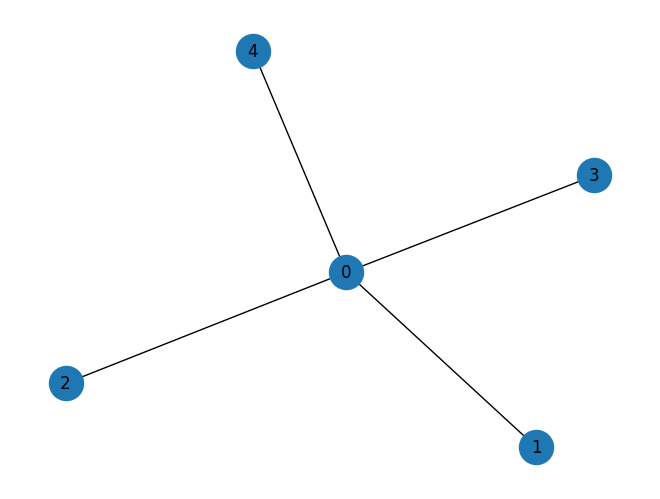

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

#graph = rx.PyGraph()
#graph.add_nodes_from(np.arange(0, n, 1))
#edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
#edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (0, 3, 1.0)]

graph = rx.undirected_gnp_random_graph(8, 0.5)

#graph.add_edges_from(edge_list)
edge_list = graph.edge_list
draw_graph(graph, node_size=600, with_labels=True)

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


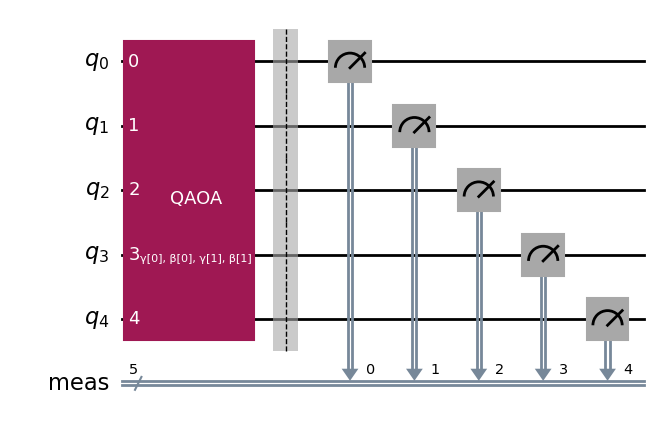

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

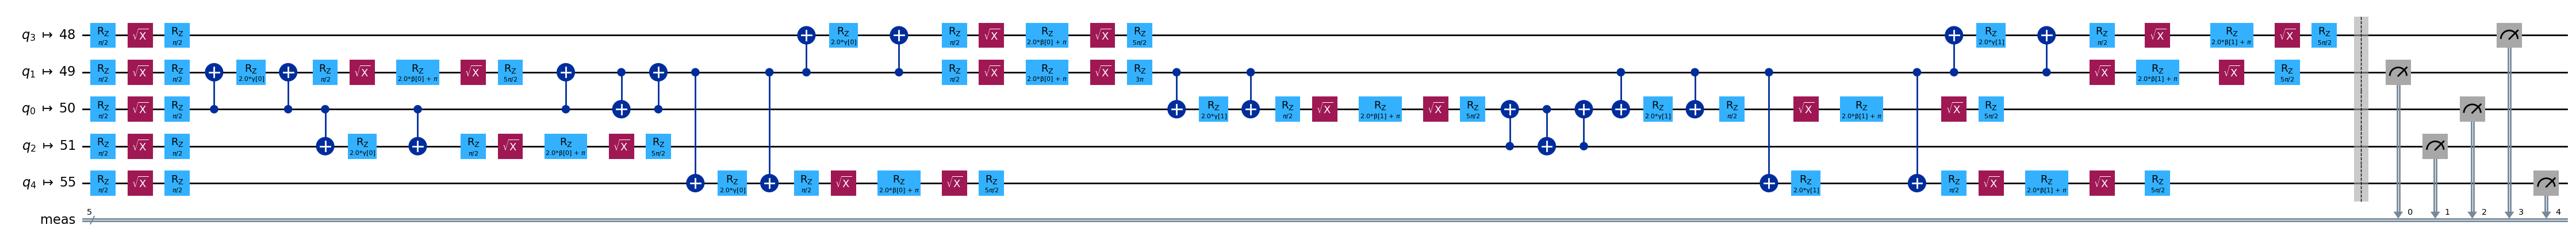

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
backend = FakeWashingtonV2()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [6]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [7]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [8]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.711288711288711
       x: [ 4.213e+00  2.820e+00  3.726e+00  4.501e-01]
    nfev: 32
   maxcv: 0.0


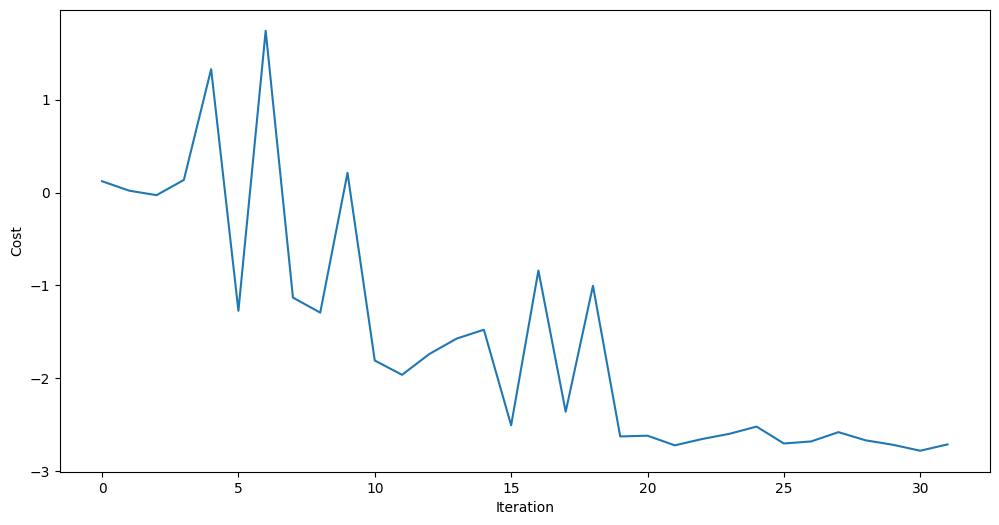

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

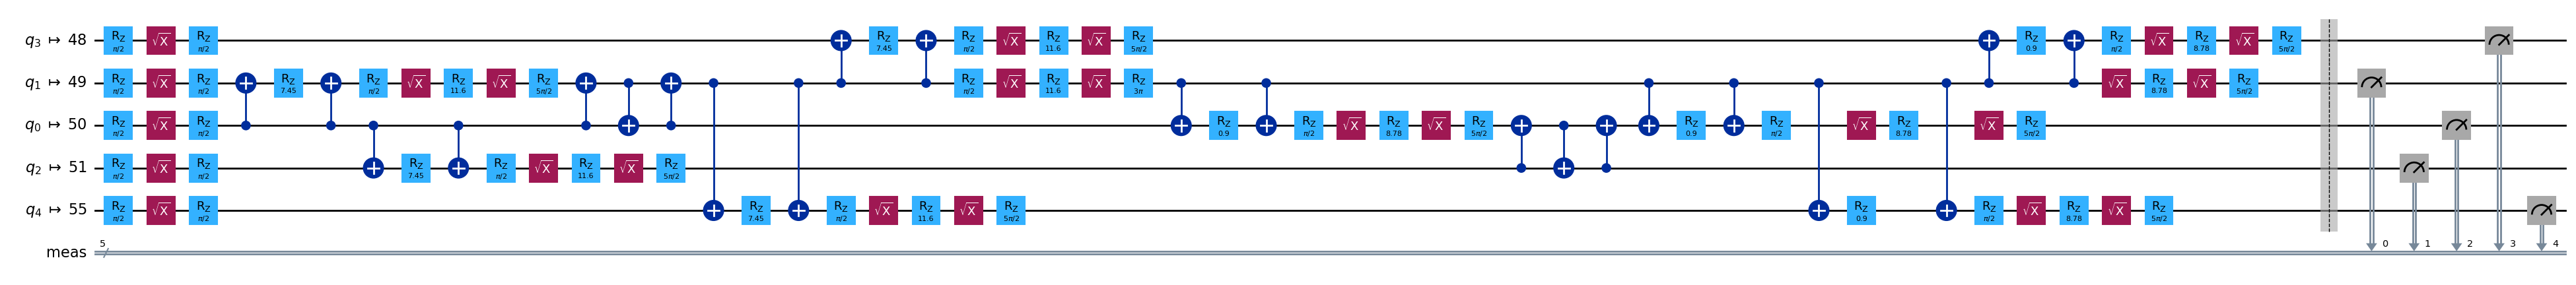

In [10]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [11]:
 /, seed=Nonefrom qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{1: 0.3597, 5: 0.0166, 30: 0.3462, 25: 0.0061, 11: 0.0037, 23: 0.0126, 26: 0.0151, 28: 0.0153, 13: 0.0038, 29: 0.0118, 0: 0.017, 10: 0.0051, 19: 0.0043, 31: 0.0083, 6: 0.0071, 24: 0.0076, 15: 0.0114, 2: 0.0126, 8: 0.0176, 4: 0.0165, 22: 0.0104, 7: 0.0103, 16: 0.0138, 12: 0.0039, 17: 0.0077, 14: 0.0118, 3: 0.0137, 20: 0.0048, 27: 0.013, 21: 0.004, 18: 0.0031, 9: 0.0051}


In [12]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 0, 0]


/tmp/ipykernel_18522/3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


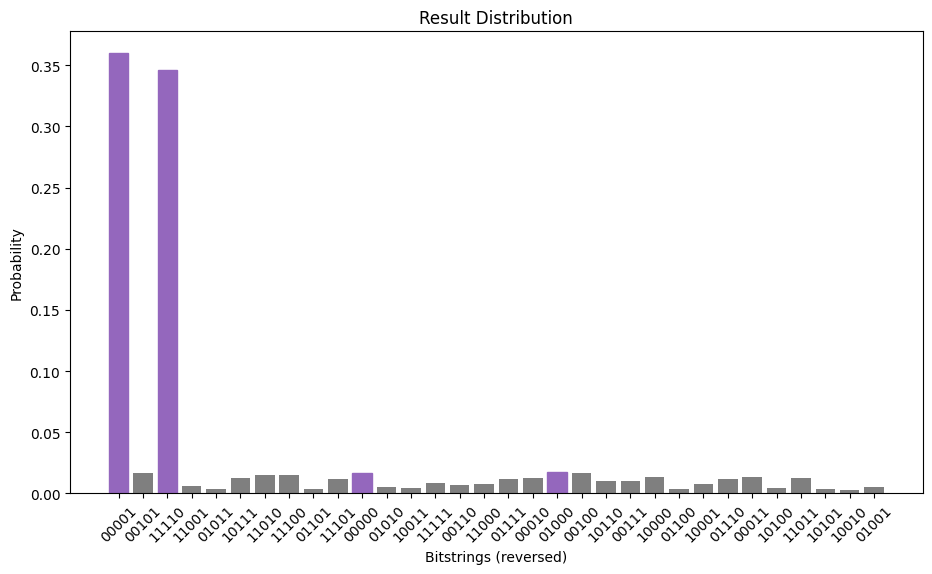

In [13]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

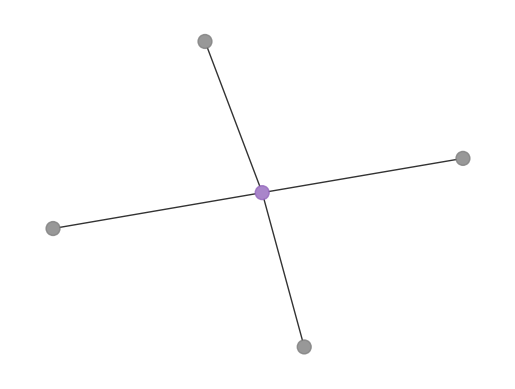

In [14]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [15]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 4


In [23]:
from qiskit_algorithms.optimizers import SPSA

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    def static_cost_func_estimator(params):
        ansatz = candidate_circuit
        hamiltonian = cost_hamiltonian
    
        # transform the observable defined on virtual qubits to
        # an observable defined on all physical qubits
        isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

        pub = (ansatz, isa_hamiltonian, params)
        job = estimator.run([pub])

        results = job.result()[0]
        cost = results.data.evs

        objective_func_vals.append(cost)

        print(cost)
        return cost

    optimizer = SPSA(maxiter=300)

    result = optimizer.minimize(fun=static_cost_func_estimator,
        x0=init_params,
        #args=(candidate_circuit, cost_hamiltonian, estimator),
        #tol=1e-2,
        )
    print(result)

0.06993006993006994
0.013986013986013988
0.0959040959040959
-1.110889110889111
-0.973026973026973
0.5294705294705295
0.01998001998001998
-1.1728271728271729
0.05594405594405595
-3.056943056943057
-0.5114885114885115
-1.8861138861138862
-0.2817182817182817
-1.6283716283716283
-2.9070929070929075
-2.3316683316683315
-2.6673326673326674
-2.8471528471528473
-2.845154845154845
-3.2747252747252746
-3.064935064935065
-2.947052947052947
-3.146853146853147
-3.144855144855145
-2.873126873126873
-3.256743256743257
-3.0349650349650346
-3.1268731268731265
-3.1248751248751248
-3.0689310689310685
-3.102897102897103
-3.116883116883117
-3.110889110889111
-3.012987012987013
-3.048951048951049
-3.040959040959041
-3.1028971028971024
-3.078921078921079
-3.1828171828171827
-2.9970029970029968
-3.016983016983017
-3.092907092907093
-3.068931068931069
-3.1108891108891106
-3.114885114885115
-3.1828171828171827
-3.142857142857143
-3.048951048951049
{   'fun': np.float64(-3.048951048951049),
    'jac': None,
    

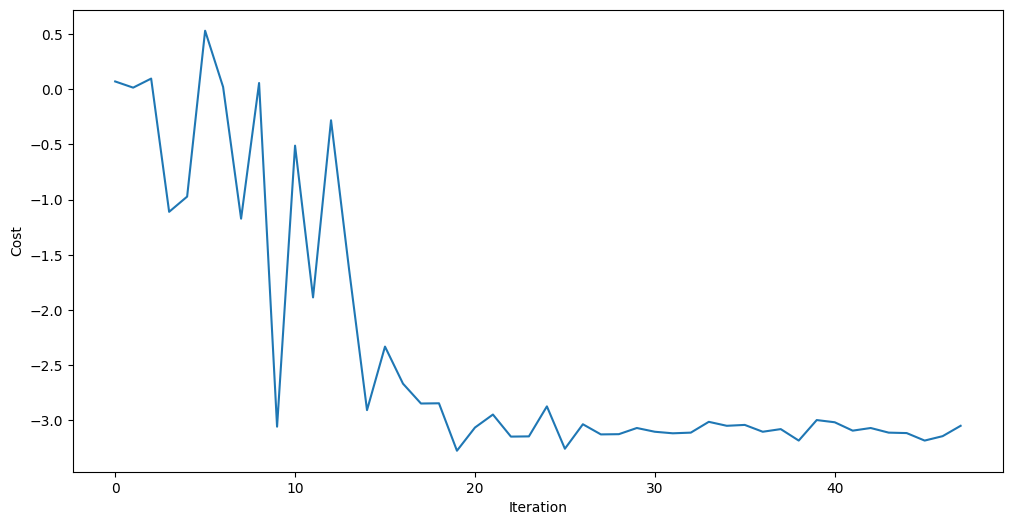

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

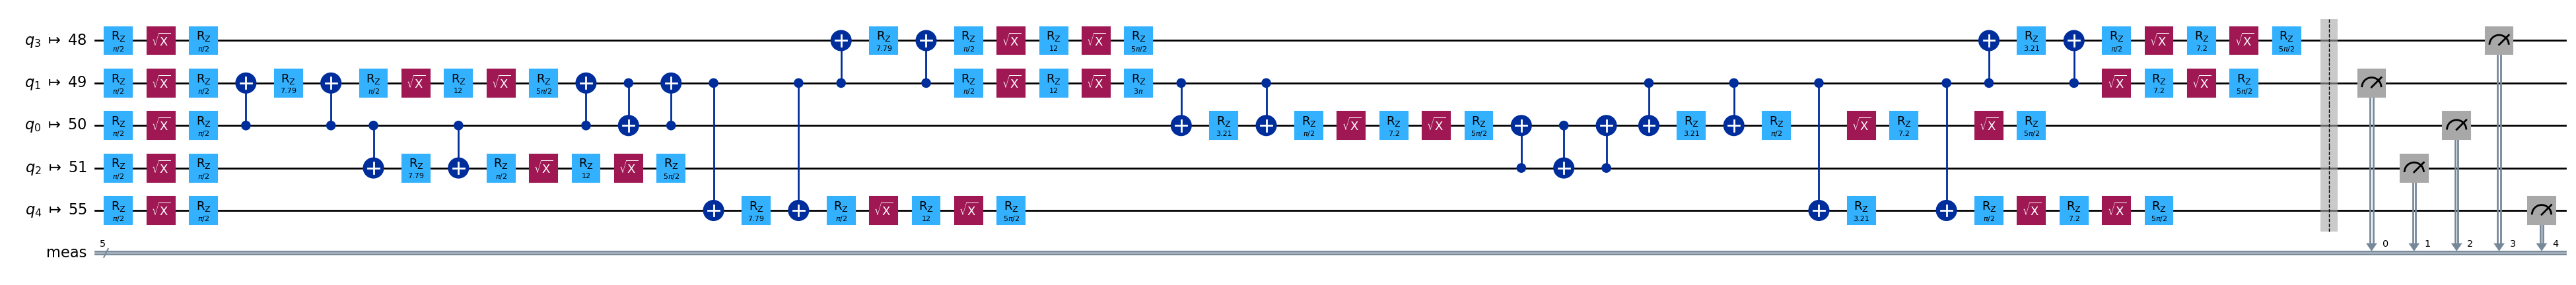

In [25]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [26]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{8: 0.006, 30: 0.4001, 26: 0.017, 1: 0.3994, 7: 0.007, 28: 0.021, 14: 0.0098, 0: 0.0215, 31: 0.0233, 15: 0.0026, 27: 0.0023, 5: 0.0198, 9: 0.008, 24: 0.0097, 3: 0.0134, 12: 0.0014, 17: 0.0093, 29: 0.0036, 18: 0.0007, 22: 0.007, 21: 0.0012, 13: 0.0004, 19: 0.0008, 23: 0.0046, 2: 0.0027, 4: 0.0023, 6: 0.0006, 11: 0.0003, 16: 0.0016, 20: 0.0005, 25: 0.001, 10: 0.0011}


In [27]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 1, 1]


/tmp/ipykernel_18522/3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


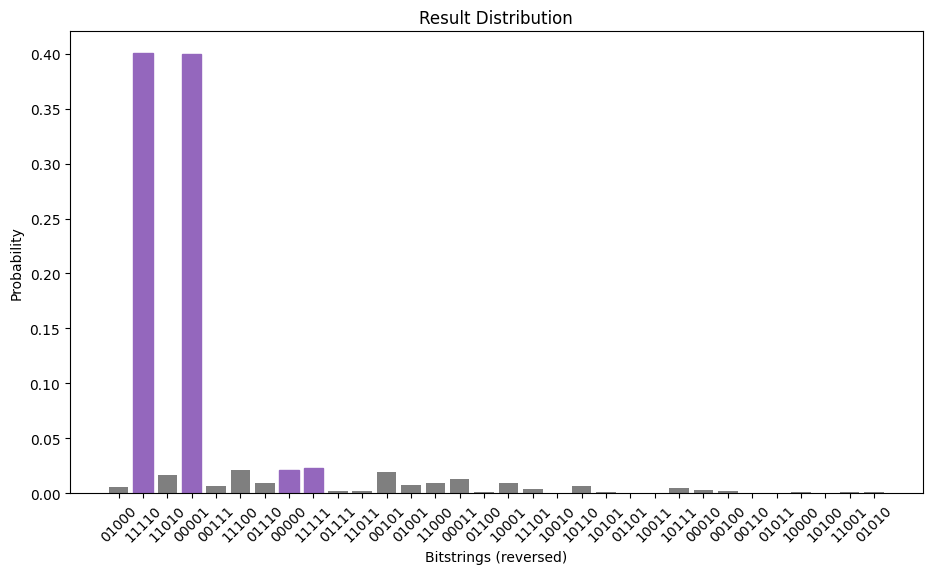

In [28]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

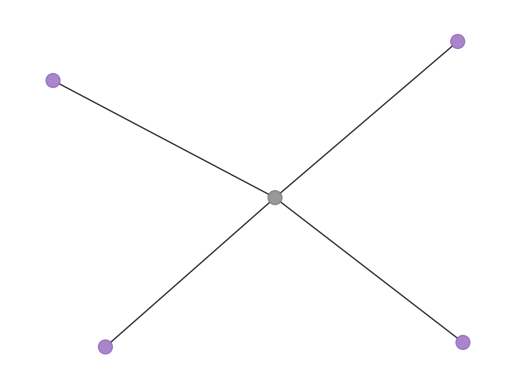

In [29]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [33]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_algorithms.optimizers import SPSA
from scipy.optimize import minimize

# Hyperparameter
alpha = 0.36  # Fraction of initial loss to switch optimizers

objective_func_vals = []

# Define the cost function for Optimization 1
def cost_func_estimator(params, circuit, hamiltonian, estimator):
    isa_hamiltonian = hamiltonian.apply_layout(circuit.layout)
    pub = (circuit, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    print(f"Cost (Optimization 1): {cost}")
    return cost

# Hybrid Optimizer
def hybrid_optimizer(init_params, candidate_circuit, cost_hamiltonian, alpha):
    global objective_func_vals
    objective_func_vals = []

    # Run Optimization 1
    print("Running Optimization 1...")
    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 1000

        # Get the initial loss value
        initial_loss = cost_func_estimator(init_params, candidate_circuit, cost_hamiltonian, estimator)

        # Define a callback to stop when the loss is reduced
        def stopping_callback(xk):
            current_loss = objective_func_vals[-1]
            return current_loss <= alpha * initial_loss

        result_1 = minimize(
            cost_func_estimator,
            init_params,
            args=(candidate_circuit, cost_hamiltonian, estimator),
            method="COBYLA",
            tol=1e-2,
            callback=stopping_callback,
        )
        print("Optimization 1 complete.")
        print(result_1)

    # Run Optimization 2 using the final parameters from Optimization 1
    print("Running Optimization 2...")
    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 1000

        # Define the cost function for Optimization 2
        def static_cost_func_estimator(params):
            isa_hamiltonian = cost_hamiltonian.apply_layout(candidate_circuit.layout)
            pub = (candidate_circuit, isa_hamiltonian, params)
            job = estimator.run([pub])
            results = job.result()[0]
            cost = results.data.evs

            objective_func_vals.append(cost)
            print(f"Cost (Optimization 2): {cost}")
            return cost

        optimizer = SPSA(maxiter=300)
        result_2 = optimizer.minimize(
            fun=static_cost_func_estimator,
            x0=result_1.x,  # Start from the results of Optimization 1
        )
        print("Optimization 2 complete.")
        print(result_2)

    return result_1, result_2


# Run the hybrid optimizer
result_1, result_2 = hybrid_optimizer(init_params, candidate_circuit, cost_hamiltonian, alpha)

Running Optimization 1...
Cost (Optimization 1): 0.03396603396603397
Cost (Optimization 1): 0.0919080919080919
Cost (Optimization 1): -0.05394605394605395
Cost (Optimization 1): 0.04395604395604395
Cost (Optimization 1): -1.0729270729270728
Cost (Optimization 1): -1.094905094905095
Cost (Optimization 1): 0.7072927072927073
Cost (Optimization 1): -1.6063936063936064
Cost (Optimization 1): -0.36163836163836166
Cost (Optimization 1): -1.006993006993007
Cost (Optimization 1): -1.3026973026973028
Cost (Optimization 1): -1.954045954045954
Cost (Optimization 1): -0.10589410589410589
Cost (Optimization 1): 0.959040959040959
Cost (Optimization 1): -1.992007992007992
Cost (Optimization 1): -1.976023976023976
Cost (Optimization 1): -1.2547452547452547
Cost (Optimization 1): -1.3146853146853148
Cost (Optimization 1): -2.2757242757242757
Cost (Optimization 1): -2.3896103896103895
Cost (Optimization 1): -1.9200799200799201
Cost (Optimization 1): -2.121878121878122
Cost (Optimization 1): -2.557442557